In [1]:
import paddle
from paddle.nn import Conv2D, Linear, Embedding
from paddle import to_tensor
import paddle.nn.functional as F
import os, zipfile
import io, random, json
import numpy as np
import matplotlib.pyplot as plt
print(paddle.__version__)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):


2.0.2


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


In [30]:
all_data_path= "all_data.txt"
f = open(all_data_path,"w")
i = 1
with open('train.txt','r') as f1:
    line =f1.readline()
    while line:
        lable = line[-2]
        if int(lable) == 2:
            break
        else:
            data = lable+'\t'+line[0:-3]+'\n'
            f.writelines(data)
            line=f1.readline()

with open('dev.txt','r') as f2:
    line =f2.readline()
    while line:
        lable = line[-2]
        if int(lable) == 2:
            break
        else:
            data = lable+'\t'+line[0:-3]+'\n'
            f.writelines(data)
            line=f2.readline()

with open('test.txt','r') as f3:
    line =f3.readline()
    while line:
        lable = line[-2]
        if int(lable) == 2:
            break
        else:
            data = lable+'\t'+line[0:-3]+'\n'
            f.writelines(data)
            line=f3.readline()

f.close()

In [24]:
# 生成数据字典
def create_dict(data_path, dict_path):
    with open(dict_path, 'w') as f:
        f.seek(0)
        f.truncate() 

    dict_set = set()
    # 读取全部数据
    with open(data_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    # 把数据生成一个元组
    for line in lines:
        content = line.split('\t')[-1].replace('\n', '')
        for s in content:
            dict_set.add(s)
    # 把元组转换成字典，一个字对应一个数字
    dict_list = []
    i = 0
    for s in dict_set:
        dict_list.append([s, i])
        i += 1
    # 添加未知字符
    dict_txt = dict(dict_list)
    end_dict = {"<unk>": i}
    dict_txt.update(end_dict)
    end_dict = {"<pad>": i+1}
    dict_txt.update(end_dict)
    # 把这些字典保存到本地中
    with open(dict_path, 'w', encoding='utf-8') as f:
        f.write(str(dict_txt))
        
    print("数据字典生成完成！")

In [25]:
# 创建序列化表示的数据,并按照一定比例划分训练数据train_list.txt与验证数据eval_list.txt
def load_vocab(file_path):
    fr = open(file_path, 'r', encoding='utf8')
    vocab = eval(fr.read())   #读取的str转换为字典
    fr.close()

    return vocab

def f_write_txt(words, dict_txt, label):
    labs = ""
    for s in words:
        lab = str(dict_txt[s])
        labs = labs + lab + ','
    labs = labs[:-1]
    labs = labs + '\t' + label + '\n'
    return labs

def create_data_list(data_path, train_path, test_path, eval_path, dict_path):
    
    dict_txt = load_vocab(dict_path)
    with open(data_path, 'r', encoding='utf-8') as f_data:
        lines = f_data.readlines()

    i = 0
    maxlen = 0
    with open(test_path, 'a', encoding='utf-8') as f_test,open(train_path, 'a', encoding='utf-8') as f_train, open(eval_path, 'a', encoding='utf-8') as f_eval:
        for line in lines:
            words = line.split('\t')[-1].replace('\n', '')
            maxlen = max(maxlen, len(words))
            label = line.split('\t')[0]
            labs = f_write_txt(words, dict_txt, label)
            # 每8个 抽取一个数据用于验证
            if i % 6 == 0:
                f_test.write(labs)
            if i % 6 == 0:
                f_eval.write(labs)
            else:
                f_train.write(labs)
            i += 1
    print("数据列表生成完成！")
    print(maxlen)


In [26]:
data_root_path = "/home/aistudio/" 
data_list_path = "/home/aistudio/" 
data_path = os.path.join(data_root_path, 'all_data.txt')
train_path = os.path.join(data_list_path, 'train.txt')
test_path = os.path.join(data_list_path, 'test.txt')
eval_path = os.path.join(data_list_path, 'dev.txt')
dict_path = os.path.join(data_root_path, "dict.txt")

# 创建数据字典
create_dict(data_path, dict_path)

# 创建数据列表

#在生成数据之前，首先将eval_list.txt和train_list.txt清空
with open(test_path, 'w', encoding='utf-8') as f_test:
    f_test.seek(0)
    f_test.truncate()
with open(train_path, 'w', encoding='utf-8') as f_train:
    f_train.seek(0)
    f_train.truncate() 
with open(eval_path, 'w', encoding='utf-8') as f_eval:
    f_eval.seek(0)
    f_eval.truncate() 

create_data_list(data_path, train_path, test_path ,eval_path, dict_path)


数据字典生成完成！
数据列表生成完成！
4292


In [27]:
# 打印前2条训练数据
vocab = load_vocab(dict_path)

def ids_to_str(ids):
    words = []
    for k in ids:
        w = list(vocab.keys())[list(vocab.values()).index(int(k))]
        words.append(w if isinstance(w, str) else w.decode('ASCII'))
    return " ".join(words)

with io.open(train_path, "r", encoding='utf8') as fin:
        i = 0
        for line in fin:
            i += 1
            cols = line.strip().split("\t")
            if len(cols) != 2:
                sys.stderr.write("[NOTICE] Error Format Line!")
                continue
            label = int(cols[1])
            wids = cols[0].split(",")
            print(str(i)+":")
            print('sentence list id is:', wids)
            print('sentence list is: ', ids_to_str(wids))
            print('sentence label id is:', label)
            print('---------------------------------')
            
            if i == 2: break


1:
sentence list id is: ['4256', '3635', '7465', '1659', '2059', '5066', '5693', '4985', '4256', '3635', '5954', '273', '2059', '6894', '1226', '960', '2255', '1783', '4554', '5035', '6305', '2408', '4487', '4256', '3635', '5954', '273', '2059', '750', '7509', '2870', '1405', '4590', '179', '4176', '4619', '1327', '6811', '1788', '4487', '4256', '3635', '5954', '273', '2059', '5066', '5693', '4985', '4256', '3635', '7465', '1659', '2059', '920', '4409', '4287', '5647', '5263', '179', '2349', '4873', '4176', '4619', '5622', '1332', '2151', '4256', '3635', '7465', '1659', '7465', '177', '2956', '1329', '3395', '3859', '2079', '4256', '3635', '7465', '1659', '5540', '6302', '5374', '3052', '179', '737', '237', '6756', '4379', '6048', '4256', '3635', '1327', '6102', '5894', '820', '1746', '1838', '1469', '2631', '5784', '7509', '6048', '4256', '3635', '5954', '273', '2059', '179', '6305', '6050', '1363', '2870', '1405', '4590', '7163', '7509', '6894', '1226', '960', '2255', '1783', '4554',

In [28]:



class RumorDataset(paddle.io.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.all_data = []
       
        with io.open(self.data_dir, "r", encoding='utf8') as fin:
            for line in fin:
                cols = line.strip().split("\t")
                if len(cols) != 2:
                    sys.stderr.write("[NOTICE] Error Format Line!")
                    continue
                label = []
                label.append(int(cols[1]))
                wids = cols[0].split(",")
                if len(wids)>=150:
                    wids = np.array(wids[:150]).astype('int64')     
                else:
                    wids = np.concatenate([wids, [vocab["<pad>"]]*(150-len(wids))]).astype('int64')
                label = np.array(label).astype('int64')
                self.all_data.append((wids, label))

        
    def __getitem__(self, index):
        data, label = self.all_data[index]
        return data, label

    def __len__(self):
        return len(self.all_data)


batch_size = 32
train_dataset = RumorDataset(train_path)
test_dataset = RumorDataset(test_path)

train_loader = paddle.io.DataLoader(train_dataset, places=paddle.CPUPlace(), return_list=True,
                                    shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = paddle.io.DataLoader(test_dataset, places=paddle.CPUPlace(), return_list=True,
                                    shuffle=True, batch_size=batch_size, drop_last=True)




#check

print('=============train_dataset =============') 
for data, label in train_dataset:
    print(data)
    print(np.array(data).shape)
    print(label)
    break


print('=============test_dataset =============') 
for data, label in test_dataset:
    print(data)
    print(np.array(data).shape)
    print(label)
    break




=============train_dataset =============
[4256 3635 7465 1659 2059 5066 5693 4985 4256 3635 5954  273 2059 6894
 1226  960 2255 1783 4554 5035 6305 2408 4487 4256 3635 5954  273 2059
  750 7509 2870 1405 4590  179 4176 4619 1327 6811 1788 4487 4256 3635
 5954  273 2059 5066 5693 4985 4256 3635 7465 1659 2059  920 4409 4287
 5647 5263  179 2349 4873 4176 4619 5622 1332 2151 4256 3635 7465 1659
 7465  177 2956 1329 3395 3859 2079 4256 3635 7465 1659 5540 6302 5374
 3052  179  737  237 6756 4379 6048 4256 3635 1327 6102 5894  820 1746
 1838 1469 2631 5784 7509 6048 4256 3635 5954  273 2059  179 6305 6050
 1363 2870 1405 4590 7163 7509 6894 1226  960 2255 1783 4554 2540 6936
 6682 2324 1327 6102 5632 1903  179 4256 3635 5954  273 2059 5066 5693
 4985 4256 3635 7465 1659 2059 6894 1226  960 2255]
(150,)
[0]
=============test_dataset =============
[4999 1662  795 4119 6984 7446 1957 3859  316 3677 7117 6243 2685  668
  179 5066 2296 3820 4280 3887 1692 2148 6894 1226  960 2255 1783 4554
 499

# CNN

In [31]:
#定义卷积网络
class CNN(paddle.nn.Layer):
    def __init__(self):
        super(CNN,self).__init__()
        self.dict_dim = vocab["<pad>"]
        self.emb_dim = 128
        self.hid_dim = 128
        self.fc_hid_dim = 96
        self.class_dim = 2
        self.channels = 1
        self.win_size = [3, self.hid_dim]
        self.batch_size = 32
        self.seq_len = 150
        self.embedding = Embedding(self.dict_dim + 1, self.emb_dim, sparse=False)
        self.hidden1 = paddle.nn.Conv2D(in_channels=1,                        #通道数
                                            out_channels=self.hid_dim,        #卷积核个数
                                            kernel_size=self.win_size,        #卷积核大小
                                            padding=[1, 1]
                                            )                         
        self.relu1 = paddle.nn.ReLU()
        self.hidden3 = paddle.nn.MaxPool2D(kernel_size=2,         #池化核大小
                                            stride=2)             #池化步长2
        self.hidden4 = paddle.nn.Linear(128*75, 2)
    #网络的前向计算过程
    def forward(self,input):
        
        #print('输入维度：', input.shape)
        x = self.embedding(input)
        x = paddle.reshape(x, [32, 1, 150, 128])   
        x = self.hidden1(x)
        x = self.relu1(x)
        #print('第一层卷积输出维度：', x.shape)
        x = self.hidden3(x)
        #print('池化后输出维度：', x.shape)
        #在输入全连接层时，需将特征图拉平会自动将数据拉平.

        x = paddle.reshape(x, shape=[self.batch_size, -1])
        out = self.hidden4(x)
        return out

epoch: 0, batch_id: 0, loss is: [0.69797945]
epoch: 0, batch_id: 20, loss is: [0.5900941]
epoch: 0, batch_id: 40, loss is: [0.33469692]
epoch: 0, batch_id: 60, loss is: [0.32655874]
epoch: 0, batch_id: 80, loss is: [0.35017884]
epoch: 0, batch_id: 100, loss is: [0.35975087]
epoch: 0, batch_id: 120, loss is: [0.36782765]
epoch: 0, batch_id: 140, loss is: [0.50655353]
epoch: 0, batch_id: 160, loss is: [0.33325815]
epoch: 0, batch_id: 180, loss is: [0.202758]
epoch: 0, batch_id: 200, loss is: [0.3368353]
epoch: 0, batch_id: 220, loss is: [0.36696118]
[validation] accuracy: 0.8799715638160706, loss: 0.30743974447250366
epoch: 1, batch_id: 0, loss is: [0.16466707]
epoch: 1, batch_id: 20, loss is: [0.07026613]
epoch: 1, batch_id: 40, loss is: [0.07788553]
epoch: 1, batch_id: 60, loss is: [0.21441215]
epoch: 1, batch_id: 80, loss is: [0.23352784]
epoch: 1, batch_id: 100, loss is: [0.09994909]
epoch: 1, batch_id: 120, loss is: [0.05189623]
epoch: 1, batch_id: 140, loss is: [0.20485087]
epoch: 

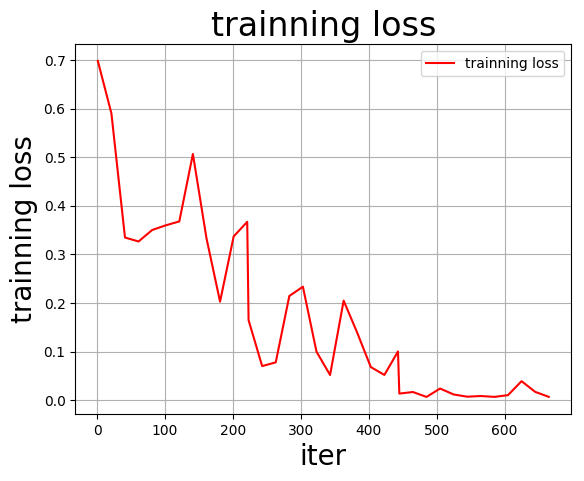

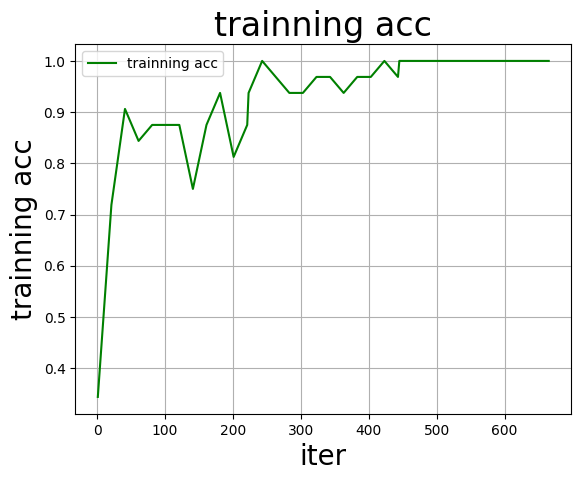

1.9665307998657227


In [32]:
def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show()

def train(model):
    model.train()
    opt = paddle.optimizer.Adam(learning_rate=0.002, parameters=model.parameters())
    steps = 0
    
    for epoch in range(3):
        for batch_id, data in enumerate(train_loader):
            steps += 1
            sent = data[0]
            label = data[1]
            logits = model(sent)
            loss = paddle.nn.functional.cross_entropy(logits, label)
            acc = paddle.metric.accuracy(logits, label)
            if batch_id % 20 == 0:
                Iters.append(steps)
                total_loss.append(loss.numpy()[0])
                total_acc.append(acc.numpy()[0])
                print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, loss.numpy()))
            
            loss.backward()
            opt.step()
            opt.clear_grad()

        # evaluate model after one epoch
        model.eval()
        accuracies = []
        losses = []
        for batch_id, data in enumerate(test_loader):
            sent = data[0]
            label = data[1]
            logits = model(sent)
            loss = paddle.nn.functional.cross_entropy(logits, label)
            acc = paddle.metric.accuracy(logits, label)
            accuracies.append(acc.numpy())
            losses.append(loss.numpy())
        
        avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)
        print("[validation] accuracy: {}, loss: {}".format(avg_acc, avg_loss))
        model.train()

    paddle.save(model.state_dict(),"model_final.pdparams")
    draw_process("trainning loss","red",Iters,total_loss,"trainning loss")
    draw_process("trainning acc","green",Iters,total_acc,"trainning acc")

Iters, total_loss, total_acc = [], [], []        
import time
a = time.time()
model = CNN()
train(model)
b=time.time()
print(b-a)

In [33]:
f1 = open("acc.txt","w")
for line in total_acc:
    f1.write(str(line)+"\n")
f1.close()

In [34]:
'''
模型评估
'''
model_state_dict = paddle.load('model_final.pdparams')
model = CNN()
model.set_state_dict(model_state_dict) 
model.eval()
accuracies = []
losses = []

for batch_id, data in enumerate(test_loader):
    
    sent = data[0]
    label = data[1]

    logits = model(sent)
    loss = paddle.nn.functional.cross_entropy(logits, label)
    acc = paddle.metric.accuracy(logits, label)
    
    accuracies.append(acc.numpy())
    losses.append(loss.numpy())

avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)
print("[validation] accuracy: {}, loss: {}".format(avg_acc, avg_loss))

[validation] accuracy: 0.8799715638160706, loss: 0.501915454864502


In [35]:
label_map = {0:"谣言", 1:"不是谣言"}
import numpy as np
from sklearn.metrics import confusion_matrix
model_state_dict = paddle.load('model_final.pdparams')
model = CNN()
model.set_state_dict(model_state_dict) 
model.eval()
predictions = []
r = []
for batch_id, data in enumerate(test_loader):
    
    sent = data[0]
    gt_labels = data[1].numpy()
    for i in gt_labels:
        r.append(i)
    results = model(sent)
    for probs in results:
        # 映射分类label
        idx = np.argmax(probs)
        #print(idx)
        #r.append(gt_labels[batch_id][probs])
        labels = label_map[idx]
        predictions.append(idx)
    
    #for i,pre in enumerate(predictions):
        #print('数据: {} \n\n预测: {} \n原始标签：{}'.format(ids_to_str(sent[0]).replace(" ", "").replace("<pad>",""), pre, label_map[gt_labels[0][0]]))
        #break
    #break
#print(r)
#print(predictions)
confusion_matrix(r, predictions)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from nested sequences exceeding the maximum number of dimensions of 32 is deprecated. If you mean to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


array([[469, 106],
       [ 63, 770]])

In [36]:
from sklearn.metrics import classification_report
target_names = ["0","1"]
CR=classification_report(r, predictions, target_names=target_names,digits=4)
print(CR)

              precision    recall  f1-score   support

           0     0.8816    0.8157    0.8473       575
           1     0.8790    0.9244    0.9011       833

    accuracy                         0.8800      1408
   macro avg     0.8803    0.8700    0.8742      1408
weighted avg     0.8801    0.8800    0.8792      1408



# LSTM

In [67]:
import paddle
from paddle.nn import Conv2D, Linear, Embedding
from paddle import to_tensor
import paddle.nn.functional as F

class RNN(paddle.nn.Layer):
    def __init__(self):
        super(RNN, self).__init__()
        self.dict_dim = vocab["<pad>"]
        self.emb_dim = 128
        self.hid_dim = 128
        self.class_dim = 2
        self.embedding = Embedding(
            self.dict_dim + 1, self.emb_dim,
            sparse=False)
        self._fc1 = Linear(self.emb_dim, self.hid_dim)
        self.lstm = paddle.nn.LSTM(self.hid_dim, self.hid_dim)
        self.fc2 = Linear(19200, self.class_dim)

    def forward(self, inputs):
        # [32, 150]
        emb = self.embedding(inputs)
        # [32, 150, 128]
        fc_1 = self._fc1(emb)
        # [32, 150, 128]
        x = self.lstm(fc_1)
        x = paddle.reshape(x[0], [0, -1])
        x = self.fc2(x)
        x = paddle.nn.functional.softmax(x)
        return x

rnn = RNN()
paddle.summary(rnn,(32,150),"int64")

-----------------------------------------------------------------------------------------------------
 Layer (type)       Input Shape                       Output Shape                      Param #    
 Embedding-37       [[32, 150]]                      [32, 150, 128]                    1,020,800   
   Linear-63      [[32, 150, 128]]                   [32, 150, 128]                     16,512     
    LSTM-27       [[32, 150, 128]]   [[32, 150, 128], [[1, 32, 128], [1, 32, 128]]]     132,096    
   Linear-64       [[32, 19200]]                        [32, 2]                         38,402     
Total params: 1,207,810
Trainable params: 1,207,810
Non-trainable params: 0
-----------------------------------------------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 142.06
Params size (MB): 4.61
Estimated Total Size (MB): 146.69
-----------------------------------------------------------------------------------------------------

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


{'total_params': 1207810, 'trainable_params': 1207810}

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py:89: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(slot[0], (np.ndarray, np.bool, numbers.Number)):


epoch: 0, batch_id: 0, loss is: [0.70328534]
epoch: 0, batch_id: 20, loss is: [0.40038016]
epoch: 0, batch_id: 40, loss is: [0.48345187]
epoch: 0, batch_id: 60, loss is: [0.41559714]
epoch: 0, batch_id: 80, loss is: [0.5573466]
epoch: 0, batch_id: 100, loss is: [0.4286052]
epoch: 0, batch_id: 120, loss is: [0.36213684]
epoch: 0, batch_id: 140, loss is: [0.56186175]
epoch: 0, batch_id: 160, loss is: [0.48349482]
epoch: 0, batch_id: 180, loss is: [0.6099056]
epoch: 0, batch_id: 200, loss is: [0.6580399]
epoch: 0, batch_id: 220, loss is: [0.4804195]
[validation] accuracy: 0.8366477489471436, loss: 0.4677758514881134
epoch: 1, batch_id: 0, loss is: [0.4757934]
epoch: 1, batch_id: 20, loss is: [0.4495434]
epoch: 1, batch_id: 40, loss is: [0.46901488]
epoch: 1, batch_id: 60, loss is: [0.49496388]
epoch: 1, batch_id: 80, loss is: [0.46749532]
epoch: 1, batch_id: 100, loss is: [0.49501973]
epoch: 1, batch_id: 120, loss is: [0.41688016]
epoch: 1, batch_id: 140, loss is: [0.45571694]
epoch: 1, b

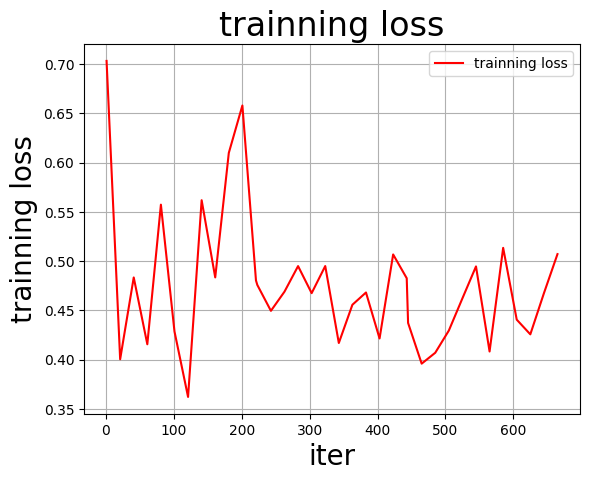

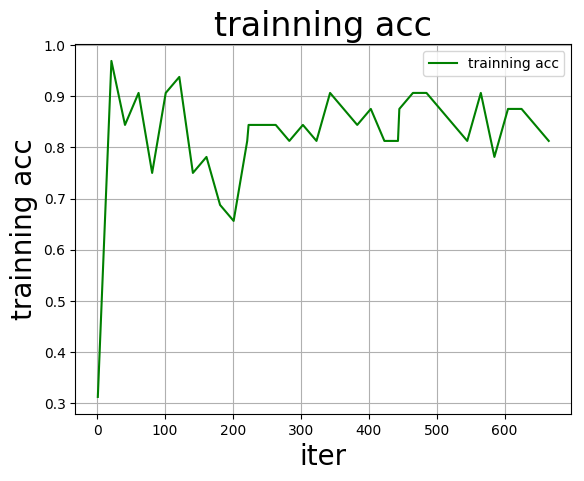

6.444181442260742


In [68]:
def train(model):
    model.train()
    opt = paddle.optimizer.Adam(learning_rate=0.002, parameters=model.parameters())
    
    steps = 0
    
    
    for epoch in range(3):
        for batch_id, data in enumerate(train_loader):
            steps += 1
            sent = data[0]
            label = data[1]
            
            logits = model(sent)
            loss = paddle.nn.functional.cross_entropy(logits, label)
            acc = paddle.metric.accuracy(logits, label)

            if batch_id % 20 == 0:
                Iters.append(steps)
                total_loss.append(loss.numpy()[0])
                total_acc.append(acc.numpy()[0])

                print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, loss.numpy()))
            
            loss.backward()
            opt.step()
            opt.clear_grad()

        # evaluate model after one epoch
        model.eval()
        accuracies = []
        losses = []
        
        for batch_id, data in enumerate(test_loader):
            
            sent = data[0]
            label = data[1]

            logits = model(sent)
            loss = paddle.nn.functional.cross_entropy(logits, label)
            acc = paddle.metric.accuracy(logits, label)
            
            accuracies.append(acc.numpy())
            losses.append(loss.numpy())
        
        avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)

        print("[validation] accuracy: {}, loss: {}".format(avg_acc, avg_loss))
        
        model.train()

    paddle.save(model.state_dict(),"lstm_model_final.pdparams")
    
    draw_process("trainning loss","red",Iters,total_loss,"trainning loss")
    draw_process("trainning acc","green",Iters,total_acc,"trainning acc")
        
Iters, total_loss, total_acc = [], [], []        
import time
start_time=time.time()
model = RNN()
train(model)
end_time=time.time()
running_time=end_time-start_time
print(running_time)

In [69]:
f1 = open("loss.txt","w")
for line in total_loss:
    f1.write(str(line)+"\n")
f1.close()

In [70]:
import numpy as np
from sklearn.metrics import confusion_matrix
model_state_dict = paddle.load('lstm_model_final.pdparams')
model = RNN()
model.set_state_dict(model_state_dict) 
model.eval()
predictions = []
r = []
for batch_id, data in enumerate(test_loader):
    
    sent = data[0]
    gt_labels = data[1].numpy()
    for i in gt_labels:
        r.append(i)
    results = model(sent)
    for probs in results:
        # 映射分类label
        idx = np.argmax(probs)
        predictions.append(idx)
    
confusion_matrix(r, predictions)
from sklearn.metrics import classification_report
target_names = ["0","1"]
CR=classification_report(r, predictions, target_names=target_names,digits=4)
print(CR)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from nested sequences exceeding the maximum number of dimensions of 32 is deprecated. If you mean to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


              precision    recall  f1-score   support

           0     0.8619    0.7599    0.8077       583
           1     0.8434    0.9139    0.8773       825

    accuracy                         0.8501      1408
   macro avg     0.8526    0.8369    0.8425      1408
weighted avg     0.8510    0.8501    0.8484      1408



# Transform

In [71]:
import paddle as pd
import paddle.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from paddlenlp.transformers import BertForSequenceClassification, BertTokenizer
from sklearn.model_selection import train_test_split
print(pd.__version__)

2.0.2


In [72]:
class MultiHeadSelfAttention(nn.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = nn.Linear(embed_dim, embed_dim)
        self.key_dense = nn.Linear(embed_dim, embed_dim)
        self.value_dense = nn.Linear(embed_dim, embed_dim)
        self.combine_heads = nn.Linear(embed_dim, embed_dim)

    def attention(self, query, key, value):
        score = pd.matmul(query, key, transpose_y=True)
        dim_key = pd.cast(pd.shape(key)[-1], 'float32')
        scaled_score = score / pd.sqrt(dim_key)
        weights = nn.functional.softmax(scaled_score, axis=-1)
        output = pd.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = pd.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return pd.transpose(x, perm=[0, 2, 1, 3])

    def forward(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = pd.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = pd.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = pd.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

In [73]:
class PointWiseFeedForwardNetwork(nn.Layer):
    def __init__(self, embed_dim, feed_dim):
        super(PointWiseFeedForwardNetwork, self).__init__()
        self.linear1 = pd.fluid.dygraph.Linear(embed_dim, feed_dim, act='relu')
        self.linear2 = nn.Linear(feed_dim, embed_dim)

    def forward(self, x):
        out = self.linear1(x)
        out = self.linear2(out)
        return out

In [74]:
class TokenAndPositionEmbedding(nn.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = nn.Embedding(vocab_size, embed_dim)
        self.pos_emb = nn.Embedding(maxlen, embed_dim)

    def forward(self, x):
        maxlen = pd.shape(x)[-1]
        positions = pd.arange(start=0, end=maxlen, step=1, dtype='int64')
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [75]:
class TransformerBlock(nn.Layer):
    def __init__(self, embed_dim, num_heads, feed_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = PointWiseFeedForwardNetwork(embed_dim, feed_dim)
        self.layernorm1 = nn.LayerNorm(embed_dim, epsilon=1e-6)
        self.layernorm2 = nn.LayerNorm(embed_dim, epsilon=1e-6)
        self.dropout1 = nn.Dropout(rate)
        self.dropout2 = nn.Dropout(rate)

    def forward(self, inputs):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [76]:
class MyNet(nn.Layer):
    def __init__(self):
        super(MyNet, self).__init__()
        self.emb = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        self.trs = TransformerBlock(embed_dim, num_heads, feed_dim)
        self.drop1 = nn.Dropout(0.1)
        self.relu = pd.fluid.dygraph.Linear(feed_dim, 20, act='relu')
        self.drop2 = nn.Dropout(0.1)
        self.soft = pd.fluid.dygraph.Linear(20, 2, act='softmax')

    def forward(self, x):
        x = self.emb(x)
        x = self.trs(x)
        x = pd.mean(x, axis=1)
        x = self.drop1(x)
        x = self.relu(x)
        x = self.drop2(x)
        x = self.soft(x)
        return x

In [77]:
#参数设置
vocab_size = len(vocab)  
maxlen = 200  
seq_len = 200
batch_size = 32
epochs = 3
pad_id = vocab['<pad>']
embed_dim = 128  # Embedding size for each token
num_heads = 2  # Number of attention heads
feed_dim = 128  # Hidden layer size in feed forward network inside transformer

classes = ['0', '1']

epoch: 0, batch_id: 0, loss is: [0.6751928]
epoch: 0, batch_id: 20, loss is: [0.6220515]
epoch: 0, batch_id: 40, loss is: [0.48182532]
epoch: 0, batch_id: 60, loss is: [0.45105875]
epoch: 0, batch_id: 80, loss is: [0.4955758]
epoch: 0, batch_id: 100, loss is: [0.47362345]
epoch: 0, batch_id: 120, loss is: [0.4782331]
epoch: 0, batch_id: 140, loss is: [0.549321]
epoch: 0, batch_id: 160, loss is: [0.42609537]
epoch: 0, batch_id: 180, loss is: [0.43985656]
epoch: 0, batch_id: 200, loss is: [0.4522249]
epoch: 0, batch_id: 220, loss is: [0.43461657]
[validation] accuracy: 0.8430397510528564, loss: 0.46492984890937805
epoch: 1, batch_id: 0, loss is: [0.44079497]
epoch: 1, batch_id: 20, loss is: [0.5261711]
epoch: 1, batch_id: 40, loss is: [0.3578046]
epoch: 1, batch_id: 60, loss is: [0.44184595]
epoch: 1, batch_id: 80, loss is: [0.4605108]
epoch: 1, batch_id: 100, loss is: [0.4306888]
epoch: 1, batch_id: 120, loss is: [0.4911983]
epoch: 1, batch_id: 140, loss is: [0.45434576]
epoch: 1, batch

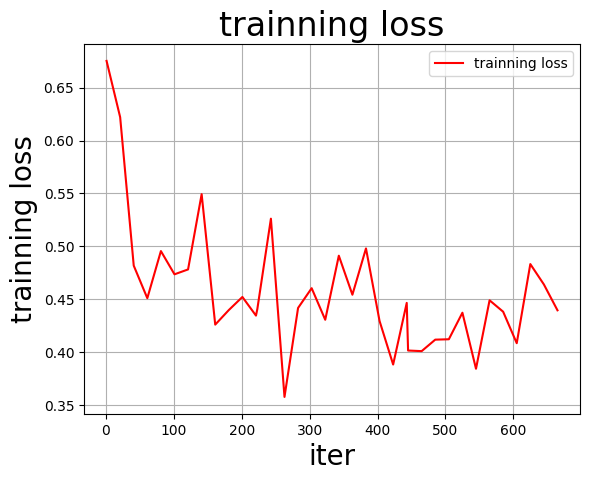

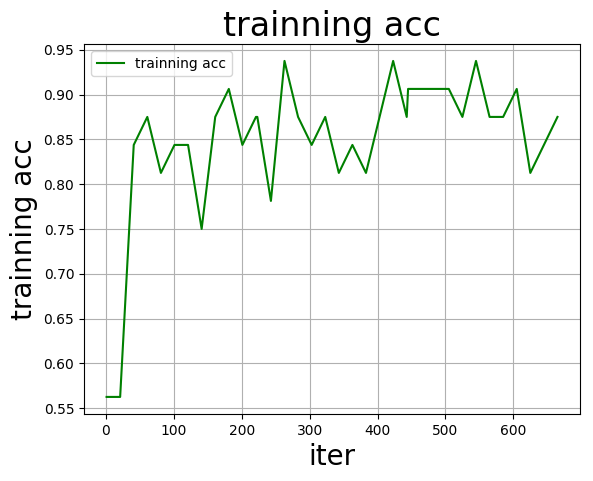

5.4384541511535645


In [78]:
def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show()

def train(model):
    model.train()
    opt = pd.optimizer.Adam(learning_rate=0.002, parameters=model.parameters())
    
    steps = 0
    
    
    for epoch in range(3):
        for batch_id, data in enumerate(train_loader):
            steps += 1
            sent = data[0]
            label = data[1]
            
            logits = model(sent)
            loss = pd.nn.functional.cross_entropy(logits, label)
            acc = pd.metric.accuracy(logits, label)

            if batch_id % 20 == 0:
                Iters.append(steps)
                total_loss.append(loss.numpy()[0])
                total_acc.append(acc.numpy()[0])

                print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, loss.numpy()))
            
            loss.backward()
            opt.step()
            opt.clear_grad()

        # evaluate model after one epoch
        model.eval()
        accuracies = []
        losses = []
        
        for batch_id, data in enumerate(test_loader):
            
            sent = data[0]
            label = data[1]

            logits = model(sent)
            loss = pd.nn.functional.cross_entropy(logits, label)
            acc = pd.metric.accuracy(logits, label)
            
            accuracies.append(acc.numpy())
            losses.append(loss.numpy())
        
        avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)

        print("[validation] accuracy: {}, loss: {}".format(avg_acc, avg_loss))
        
        model.train()

    pd.save(model.state_dict(),"trans_model_final.pdparams")
    
    draw_process("trainning loss","red",Iters,total_loss,"trainning loss")
    draw_process("trainning acc","green",Iters,total_acc,"trainning acc")

import time
a = time.time()
Iters, total_loss, total_acc = [], [], []
model = MyNet()
train(model)
b = time.time()
print(b-a)

In [79]:
f1 = open("loss.txt","w")
for line in total_loss:
    f1.write(str(line)+"\n")
f1.close()

In [80]:
import numpy as np
from sklearn.metrics import confusion_matrix
model_state_dict = paddle.load('trans_model_final.pdparams')
model = MyNet()
model.set_state_dict(model_state_dict) 
model.eval()
predictions = []
r = []
for batch_id, data in enumerate(test_loader):
    
    sent = data[0]
    gt_labels = data[1].numpy()
    for i in gt_labels:
        r.append(i)
    results = model(sent)
    for probs in results:
        # 映射分类label
        idx = np.argmax(probs)
        predictions.append(idx)
    
confusion_matrix(r, predictions)
from sklearn.metrics import classification_report
target_names = ["0","1"]
CR=classification_report(r, predictions, target_names=target_names,digits=4)
print(CR)

              precision    recall  f1-score   support

           0     0.8843    0.6959    0.7788       582
           1     0.8137    0.9358    0.8705       826

    accuracy                         0.8366      1408
   macro avg     0.8490    0.8159    0.8247      1408
weighted avg     0.8429    0.8366    0.8326      1408



# GRU

In [96]:
batch_size = 32
epochs = 3

#词汇表总数
vocab_size = len(vocab) + 1
print(vocab_size)


emb_size = 256
#句子固定长度
seq_len = 150



#补齐词的id编号
pad_id = vocab["<pad>"]

#类别
classes = ['negative', 'positive']

7976


In [97]:
import paddle.nn as nn
import paddle
# 定义GRU网络
class MyGRU(paddle.nn.Layer):
    def __init__(self):
        super(MyGRU, self).__init__()

        #将词汇表中的每个词映射为256维向量，以避免one-hot编码带来的稀疏性
        self.embedding = nn.Embedding(vocab_size, emb_size)

        #定义模型
        # 这里的input_size就是词向量的维度，hidden_size就是RNN隐藏层的维度
        # 并不需要指定时间步数，也即seq_len，这是因为，GRU和LSTM都实现了自身的迭代
        self.gru = nn.GRU(input_size=emb_size, hidden_size=256, num_layers=2, direction='bidirectional',dropout=0.5)
        self.linear = nn.Linear(in_features=256*2, out_features=2)  #二分类问题，情感分为积极和消极
        self.dropout = nn.Dropout(p=0.5)
    

    def forward(self, inputs):
        
        #词嵌入
        #inputs大小为句子长度*embedding向量大小=200*256
        #emb大小为 [32, 200, 256]
        emb = self.dropout(self.embedding(inputs))

        #调用gru        
        output, hidden = self.gru(emb)
        #output形状大小为[32, 200, 512]=[batch_size,seq_len,num_directions * hidden_size]
        #hidden形状大小为[4, 32, 256]=[num_layers * num_directions, batch_size, hidden_size]

        #把前向的hidden与后向的hidden（大小为[32, 256]）合并在一起，对axis=1进行运算
        hidden = paddle.concat((hidden[-2,:,:], hidden[-1,:,:]), axis = 1)
        #合并后，hidden形状大小为[32, 512]=[batch_size, hidden_size * num_directions]        

        hidden = self.dropout(hidden)
        return self.linear(hidden)

In [98]:
def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show()

epoch: 0, batch_id: 0, loss is: [0.7015072]
epoch: 0, batch_id: 20, loss is: [0.6533925]
epoch: 0, batch_id: 40, loss is: [0.46181595]
epoch: 0, batch_id: 60, loss is: [0.4825068]
epoch: 0, batch_id: 80, loss is: [0.4456603]
epoch: 0, batch_id: 100, loss is: [0.17415377]
epoch: 0, batch_id: 120, loss is: [0.3437603]
epoch: 0, batch_id: 140, loss is: [0.41518012]
epoch: 0, batch_id: 160, loss is: [0.32090238]
epoch: 0, batch_id: 180, loss is: [0.37683064]
epoch: 0, batch_id: 200, loss is: [0.20779213]
[validation] accuracy: 0.8555424809455872, loss: 0.3619607388973236
epoch: 1, batch_id: 0, loss is: [0.19533]
epoch: 1, batch_id: 20, loss is: [0.3758583]
epoch: 1, batch_id: 40, loss is: [0.14952928]
epoch: 1, batch_id: 60, loss is: [0.15813324]
epoch: 1, batch_id: 80, loss is: [0.18964943]
epoch: 1, batch_id: 100, loss is: [0.35594615]
epoch: 1, batch_id: 120, loss is: [0.19588354]
epoch: 1, batch_id: 140, loss is: [0.42311233]
epoch: 1, batch_id: 160, loss is: [0.3626388]
epoch: 1, batc

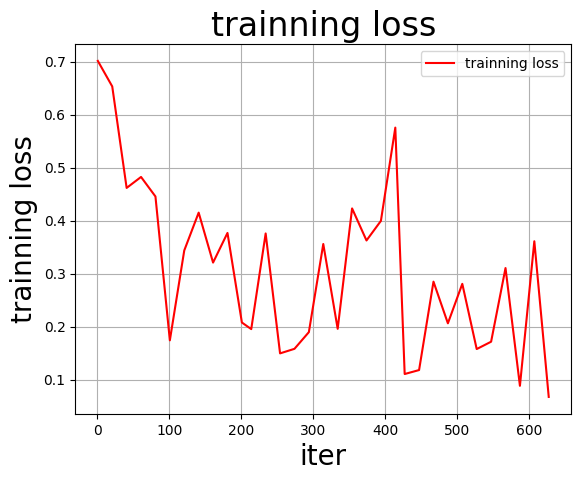

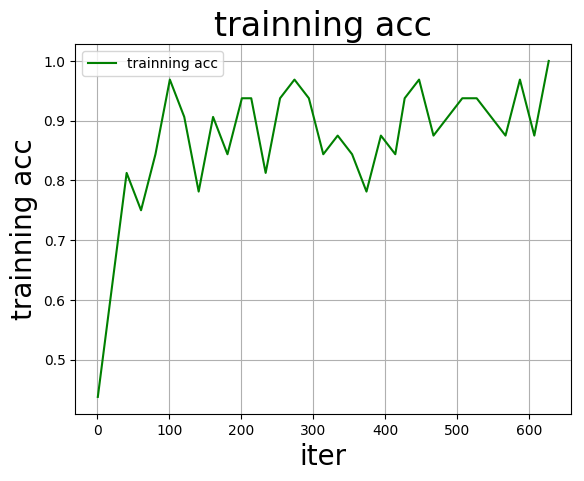

20.963518142700195


In [119]:
# 对模型进行封装
def train(model):
    model.train()
    opt = paddle.optimizer.Adam(learning_rate=0.002, parameters=model.parameters())
    steps = 0
    

    for epoch in range(epochs):
        for batch_id, data in enumerate(train_loader):
            steps += 1
            #每次送入一个batch的数据,sent大小为[32, 200]
            sent = data[0]
            label = data[1]            
            #送入模型            
            logits = model(sent)
            loss = paddle.nn.functional.cross_entropy(logits, label)
            acc = paddle.metric.accuracy(logits, label)

            if batch_id % 20 == 0:  # 500个epoch输出一次结果
                Iters.append(steps)
                total_loss.append(loss.numpy()[0])
                total_acc.append(acc.numpy()[0])

                print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, loss.numpy()))
            
            loss.backward()
            opt.step()
            opt.clear_grad()

        # evaluate model after one epoch
        model.eval()
        accuracies = []
        losses = []
        
        for batch_id, data in enumerate(test_loader):
            
            sent = data[0]
            label = data[1]

            logits = model(sent)
            loss = paddle.nn.functional.cross_entropy(logits, label)
            acc = paddle.metric.accuracy(logits, label)
            
            accuracies.append(acc.numpy())
            losses.append(loss.numpy())
        
        avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)

        print("[validation] accuracy: {}, loss: {}".format(avg_acc, avg_loss))
        
        model.train()

        # 保存模型
    paddle.save(model.state_dict(),"gru_model_final.pdparams")
    
    # 可视化查看
    draw_process("trainning loss","red",Iters,total_loss,"trainning loss")
    draw_process("trainning acc","green",Iters,total_acc,"trainning acc")
import time 
a = time.time()
Iters, total_loss, total_acc = [], [], []       
model = MyGRU()
train(model)
b = time.time()
print(b-a)

In [114]:
f1 = open("loss.txt","w")
for line in total_loss:
    f1.write(str(line)+"\n")
f1.close()

In [120]:
import numpy as np
from sklearn.metrics import confusion_matrix
model_state_dict = paddle.load('gru_model_final.pdparams')
model = MyGRU()
model.set_state_dict(model_state_dict) 
model.eval()
predictions = []
r = []
for batch_id, data in enumerate(test_loader):
    
    sent = data[0]
    gt_labels = data[1].numpy()
    for i in gt_labels:
        r.append(i)
    results = model(sent)
    for probs in results:
        # 映射分类label
        idx = np.argmax(probs)
        predictions.append(idx)
    
confusion_matrix(r, predictions)
from sklearn.metrics import classification_report
target_names = ["0","1"]
CR=classification_report(r, predictions, target_names=target_names,digits=4)
print(CR)

              precision    recall  f1-score   support

           0     0.8005    0.8734    0.8354       703
           1     0.9042    0.8459    0.8741       993

    accuracy                         0.8573      1696
   macro avg     0.8524    0.8597    0.8547      1696
weighted avg     0.8612    0.8573    0.8580      1696



##  BERT

In [85]:
!pip install --upgrade paddlenlp==2.0.0b4 -i https://pypi.org/simple


[notice] A new release of pip available: 22.1.2 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [86]:
import re
import jieba
import os 
import random
import paddle
import paddlenlp as ppnlp
from paddlenlp.data import Stack, Pad, Tuple
import paddle.nn.functional as F
import paddle.nn as nn
from visualdl import LogWriter
import numpy as np
from functools import partial #partial()函数可以用来固定某些参数值，并返回一个新的callable对象
import os, zipfile
import io, random, json
print(paddle.__version__)

2.0.2


In [87]:
f=open("eval_list.txt","w")

with io.open(eval_path, "r", encoding='utf8') as fin:
        i = 0
        for line in fin:
            i += 1
            cols = line.strip().split("\t")
            if len(cols) != 2:
                sys.stderr.write("[NOTICE] Error Format Line!")
                continue
            label = int(cols[1])
            wids = cols[0].split(",")
            strline = ids_to_str(wids) + "\t" + str(label) + "\n"
            f.writelines(strline)

In [88]:
f=open("train_list.txt","w")

with io.open(train_path, "r", encoding='utf8') as fin:
        i = 0
        for line in fin:
            i += 1
            cols = line.strip().split("\t")
            if len(cols) != 2:
                sys.stderr.write("[NOTICE] Error Format Line!")
                continue
            label = int(cols[1])
            wids = cols[0].split(",")
            strline = ids_to_str(wids) + "\t" + str(label) + "\n"
            f.writelines(strline)

KeyboardInterrupt: 

In [ ]:
f=open("test_list.txt","w")

with io.open(test_path, "r", encoding='utf8') as fin:
        i = 0
        for line in fin:
            i += 1
            cols = line.strip().split("\t")
            if len(cols) != 2:
                sys.stderr.write("[NOTICE] Error Format Line!")
                continue
            label = int(cols[1])
            wids = cols[0].split(",")
            strline = ids_to_str(wids) + "\t" + str(label) + "\n"
            f.writelines(strline)


In [ ]:
#数据处理已经做好可以从这里开始运行代码
class SelfDefinedDataset(paddle.io.Dataset):
    def __init__(self, data):
        super(SelfDefinedDataset, self).__init__()
        self.data = data

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)
        
    def get_labels(self):
        return ["0", "1"]

def txt_to_list(file_name):
    res_list = []
    for line in open(file_name):
        res_list.append(line.strip().split('\t'))
    return res_list

trainlst = txt_to_list('train_list.txt')
devlst = txt_to_list('eval_list.txt')
testlst = txt_to_list('test_list.txt')

train_ds, dev_ds, test_ds = SelfDefinedDataset.get_datasets([trainlst, devlst, testlst])

In [ ]:

label_list = train_ds.get_labels()
#看看数据长什么样子，分别打印训练集、验证集、测试集的前3条数据。
print("训练集数据：{}\n".format(train_ds[0:3]))
print("验证集数据:{}\n".format(dev_ds[0:3]))
print("测试集数据:{}\n".format(test_ds[0:3]))

print("训练集样本个数:{}".format(len(train_ds)))
print("验证集样本个数:{}".format(len(dev_ds)))
print("测试集样本个数:{}".format(len(test_ds)))

In [ ]:

#验证清洗脏数据
for line in test_ds:
    if len(line) != 2:
        print("error")
        print(line)

In [ ]:
tokenizer = ppnlp.transformers.BertTokenizer.from_pretrained("bert-base-chinese")

#数据预处理
def convert_example(example,tokenizer,label_list,max_seq_length=256,is_test=False):
    if is_test:
        text = example
    else:
        text, label = example
    #tokenizer.encode方法能够完成切分token，映射token ID以及拼接特殊token
    encoded_inputs = tokenizer.encode(text=text, max_seq_len=max_seq_length)
    input_ids = encoded_inputs["input_ids"]
    #注意，在早前的PaddleNLP版本中，token_type_ids叫做segment_ids
    segment_ids = encoded_inputs["segment_ids"]

    if not is_test:
        label_map = {}
        for (i, l) in enumerate(label_list):
            label_map[l] = i

        label = label_map[label]
        label = np.array([label], dtype="int64")
        return input_ids, segment_ids, label
    else:
        return input_ids, segment_ids

#数据迭代器构造方法
def create_dataloader(dataset, trans_fn=None, mode='train', batch_size=1, use_gpu=False, pad_token_id=0, batchify_fn=None):
    if trans_fn:
        dataset = dataset.apply(trans_fn, lazy=True)

    if mode == 'train' and use_gpu:
        sampler = paddle.io.DistributedBatchSampler(dataset=dataset, batch_size=batch_size, shuffle=True)
    else:
        shuffle = True if mode == 'train' else False #如果不是训练集，则不打乱顺序
        sampler = paddle.io.BatchSampler(dataset=dataset, batch_size=batch_size, shuffle=shuffle) #生成一个取样器
    dataloader = paddle.io.DataLoader(dataset, batch_sampler=sampler, return_list=True, collate_fn=batchify_fn)
    return dataloader

#使用partial()来固定convert_example函数的tokenizer, label_list, max_seq_length, is_test等参数值
trans_fn = partial(convert_example, tokenizer=tokenizer, label_list=label_list, max_seq_length=128, is_test=False)
batchify_fn = lambda samples, fn=Tuple(Pad(axis=0,pad_val=tokenizer.pad_token_id), Pad(axis=0, pad_val=tokenizer.pad_token_id), Stack(dtype="int64")):[data for data in fn(samples)]
#训练集迭代器
train_loader = create_dataloader(train_ds, mode='train', batch_size=32, batchify_fn=batchify_fn, trans_fn=trans_fn)
#验证集迭代器
dev_loader = create_dataloader(dev_ds, mode='dev', batch_size=1, batchify_fn=batchify_fn, trans_fn=trans_fn)
#测试集迭代器
test_loader = create_dataloader(test_ds, mode='test', batch_size=32, batchify_fn=batchify_fn, trans_fn=trans_fn)

In [ ]:
model = ppnlp.transformers.BertForSequenceClassification.from_pretrained("bert-base-chinese", num_classes=2)

In [ ]:
#设置训练超参数

#学习率1e-5 
learning_rate = 0.0002
#训练轮次
epochs = 2
#学习率预热比率
warmup_proption = 0.1
#权重衰减系数
weight_decay = 0.01

num_training_steps = len(train_loader) * epochs
num_warmup_steps = int(warmup_proption * num_training_steps)

def get_lr_factor(current_step):
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))
    else:
        return max(0.0,
                    float(num_training_steps - current_step) /
                    float(max(1, num_training_steps - num_warmup_steps)))
#学习率调度器
lr_scheduler = paddle.optimizer.lr.LambdaDecay(learning_rate, lr_lambda=lambda current_step: get_lr_factor(current_step))

#优化器
optimizer = paddle.optimizer.AdamW(
    learning_rate=lr_scheduler,
    parameters=model.parameters(),
    weight_decay=weight_decay,
    apply_decay_param_fun=lambda x: x in [
        p.name for n, p in model.named_parameters()
        if not any(nd in n for nd in ["bias", "norm"])
    ])

#损失函数
criterion = paddle.nn.loss.CrossEntropyLoss()
#评估函数
metric = paddle.metric.Accuracy()

In [ ]:
def evaluate(model, criterion, metric, data_loader):
    model.eval()
    metric.reset()
    losses = []
    for batch in data_loader:
        input_ids, segment_ids, labels = batch
        logits = model(input_ids, segment_ids)
        loss = criterion(logits, labels)
        losses.append(loss.numpy())
        correct = metric.compute(logits, labels)
        metric.update(correct)
        accu = metric.accumulate()
    print("eval loss: %.5f, accu: %.5f" % (np.mean(losses), accu))
    model.train()
    metric.reset()
    return np.mean(losses), accu

In [ ]:
global_step = 0
with LogWriter(logdir="./log") as writer:
    for epoch in range(1, epochs + 1):    
        for step, batch in enumerate(train_loader, start=1): #从训练数据迭代器中取数据
            input_ids, segment_ids, labels = batch
            #print(segment_ids)
            logits = model(input_ids, segment_ids)
            loss = criterion(logits, labels) #计算损失
            probs = F.softmax(logits, axis=1)
            correct = metric.compute(probs, labels)
            metric.update(correct)
            acc = metric.accumulate()
            # print(acc)

            global_step += 1
            if global_step % 50 == 0 :
                print("global step %d, epoch: %d, batch: %d, loss: %.5f, acc: %.5f" % (global_step, epoch, step, loss, acc))
                #记录训练过程
                writer.add_scalar(tag="train/loss", step=global_step, value=loss)
                writer.add_scalar(tag="train/acc", step=global_step, value=acc)
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.clear_gradients()
        eval_loss, eval_acc = evaluate(model, criterion, metric, dev_loader)
        #记录评估过程
        writer.add_scalar(tag="eval/loss", step=epoch, value=eval_loss)
        writer.add_scalar(tag="eval/acc", step=epoch, value=eval_acc)

In [ ]:
def predict(model, data, tokenizer, label_map, batch_size=1):
    examples = []
    results = []
    lable = []
    model.eval()
    for batch in data:
        input_ids, segment_ids, labels = batch
        input_ids = paddle.to_tensor(input_ids)
        segment_ids = paddle.to_tensor(segment_ids)
        logits = model(input_ids, segment_ids)
        probs = F.softmax(logits, axis=1)
        idx = paddle.argmax(probs, axis=1).numpy()
        idx = idx.tolist()
        # print(labels.numpy().tolist())
        # labels = [label_map[i] for i in idx]
        results.extend(idx)
        lable.extend(labels.numpy().tolist()[0])
    return results,lable

In [ ]:
label_map = {0: '谣言', 1: '不是谣言'}
predictions,r = predict(model, dev_loader, tokenizer, label_map, batch_size=1)

from sklearn.metrics import classification_report
target_names = ["0","1"]
CR=classification_report(r, predictions, target_names=target_names,digits=4)
print(CR)